In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from dataretrieval import nwis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans


I chose to analyze some data from Austin Camp Mabry in Texas for its long-term data coverage and high completeness.
Spanning from 1940 to 2020, it offers one of the most continuous and uninterrupted climate records in Texas.
The consistent dataset is crucial for detecting meaningful long-term climate trends.

In [2]:
#Loading the CSV file

df = pd.read_csv("Austin Camp Mabry_Texas_Weather.csv")
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,CDSD,DSND,DSNW,...,WDF2,WDF5,WDFG,WDFM,WDMV,WSF1,WSF2,WSF5,WSFG,WSFM
0,USW00013958,"AUSTIN CAMP MABRY, TX US",30.3208,-97.7604,204.2,1940,NaN,2444,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013958,"AUSTIN CAMP MABRY, TX US",30.3208,-97.7604,204.2,1941,NaN,2814,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00013958,"AUSTIN CAMP MABRY, TX US",30.3208,-97.7604,204.2,1942,NaN,2555,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00013958,"AUSTIN CAMP MABRY, TX US",30.3208,-97.7604,204.2,1943,NaN,2780,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00013958,"AUSTIN CAMP MABRY, TX US",30.3208,-97.7604,204.2,1944,NaN,2655,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here are the data types

EMXP - Extreme maximum precipitation for the period,
PRCP - Precipitation,
EMSN - Extreme maximum snowfall for the period.
DSND - Number days with snow depth > 1 inch(25.4mm) for the period,
SNOW - Snowfall,
EMSD - Extreme maximum snow depth for the period,
DSNW - Number days with snow depth > 1 inch,

EMNT - Extreme minimum temperature for the period,
EMXT - Extreme maximum temperature for the period,
HDSD - Heating Degree Days Season to Date,
CDSD - Cooling Degree Days Season to Date,
TAVG - Average Temperature,
TMIN - Minimum temperature,
TMAX - Maximum temperature,

WSFM - Fastest mile wind speed,
WDF1 - Direction of fastest 1-minute wind,
WDF2 - Direction of fastest 2-minute wind,
WDF5 - Direction of fastest 5-second wind,
WDMV - Total wind movement,
WSF2 - Fastest 2-minute wind speed,
WSF5 - Fastest 5-second wind speed,
WDFG - Direction of peak wind gust,
WSF1 - Fastest 1-minute wind speed,
AWND - Average wind speed,
WSFG - Peak gust wind speed,
WDFM - Fastest mile wind direction

In [3]:
#Removing some columns

cols_to_drop = ['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DSND', 'DSNW', 'HDSD', 'CDSD',
               'WSFM', 'WDF1', 'WDF2', 'WDF5', 'WDMV', 'WSF2', 'WSF5', 'WDFG', 'WSF1', 'WSFG', 'WDFM', 'EMSD']
df_clean = df.drop(columns=cols_to_drop)
df_clean.head()

,STATION,DATE,AWND,EMNT,EMSN,EMXP,EMXT,PRCP,SNOW,TAVG,TMAX,TMIN
0,USW00013958,1940,NaN,10,2.0,3.00,102,38.97,2.0,65.9,77.4,54.3
1,USW00013958,1941,NaN,26,0.0,3.20,100,45.41,0.0,67.7,77.6,57.8
2,USW00013958,1942,NaN,18,0.0,2.60,101,32.22,0.0,67.2,78.0,56.3
3,USW00013958,1943,NaN,13,0.0,2.65,104,24.76,0.0,67.5,78.5,56.6
4,USW00013958,1944,NaN,19,3.9,3.90,103,42.98,7.0,67.2,77.4,57.0


In [35]:
#Renaming some columns and rearranging them

df_clean = df_clean.rename(columns = {
    'AWND' : 'Avg Wind Speed', 'EMNT' : 'Extreme Min Temp', 'EMSN' : 'Ext. Max Snowfall', 'EMXP' : 'Ext. Max Prcp',
    'EMXT' : 'Ext. Max Temp', 'PRCP' : 'Precipitation', 'TAVG' : 'Avg. Temp', 'TMAX' : 'Max Temp', 'TMIN' : 'Min Temp',
    'DATE' : 'YEAR'})

new_order = ['STATION', 'YEAR', 'Avg. Temp', 'Min Temp', 'Max Temp', 'Extreme Min Temp', 'Ext. Max Temp', 'Precipitation',
            'Ext. Max Prcp', 'SNOW', 'Ext. Max Snowfall']
df_clean = df_clean[new_order]
df_clean.head()


,STATION,YEAR,Avg. Temp,Min Temp,Max Temp,Extreme Min Temp,Ext. Max Temp,Precipitation,Ext. Max Prcp,SNOW,Ext. Max Snowfall
0,USW00013958,1940,65.9,54.3,77.4,10,102,38.97,3.00,2.0,2.0
1,USW00013958,1941,67.7,57.8,77.6,26,100,45.41,3.20,0.0,0.0
2,USW00013958,1942,67.2,56.3,78.0,18,101,32.22,2.60,0.0,0.0
3,USW00013958,1943,67.5,56.6,78.5,13,104,24.76,2.65,0.0,0.0
4,USW00013958,1944,67.2,57.0,77.4,19,103,42.98,3.90,7.0,3.9


In [36]:
df_clean.shape

(85, 11)

In [5]:
#Checking Missing Data

df_clean.isna().sum()

STATION              0
YEAR                 0
Avg. Temp            0
Min Temp             0
Max Temp             0
Extreme Min Temp     0
Ext. Max Temp        0
Precipitation        0
Ext. Max Prcp        0
SNOW                 0
Ext. Max Snowfall    0
dtype: int64

There is no missing. This is great!

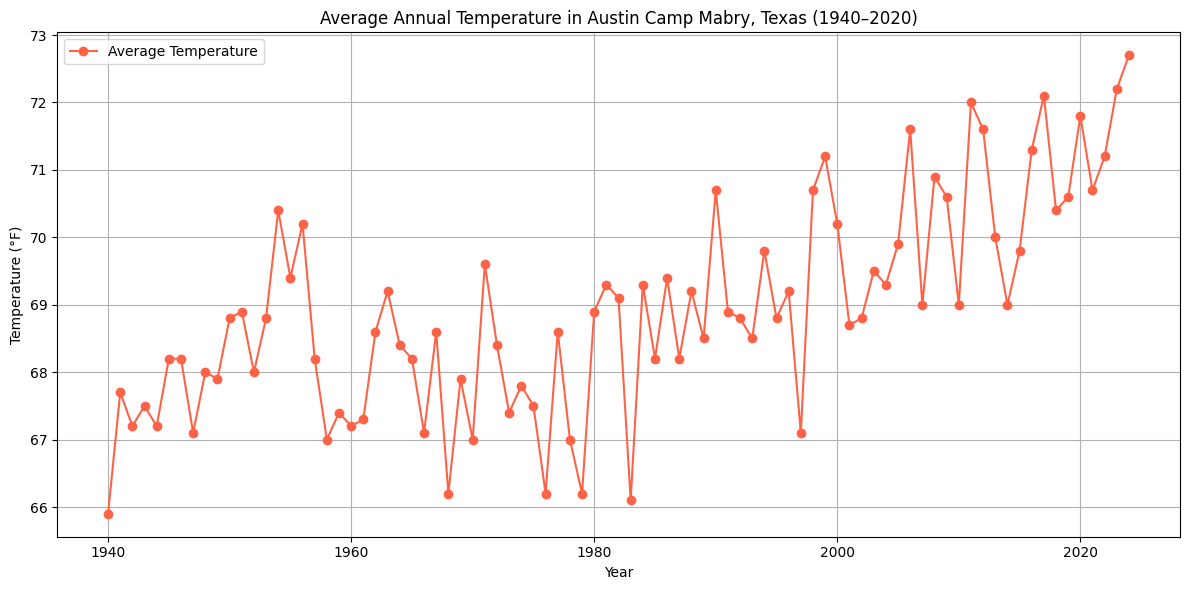

In [6]:
#Plotting Average Temperature Over Time (1940 - 2020)

plt.figure(figsize=(12, 6))
plt.plot(df_clean['YEAR'], df_clean['Avg. Temp'], marker='o', label='Average Temperature', color='tomato')
plt.title('Average Annual Temperature in Austin Camp Mabry, Texas (1940–2020)')
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From 1940 to 2020, the average temperature in Austin Camp Mabry, Texas is fluctuating but surely increasing over decades.
The rate of temperature increase appears to accelerate after 2000.

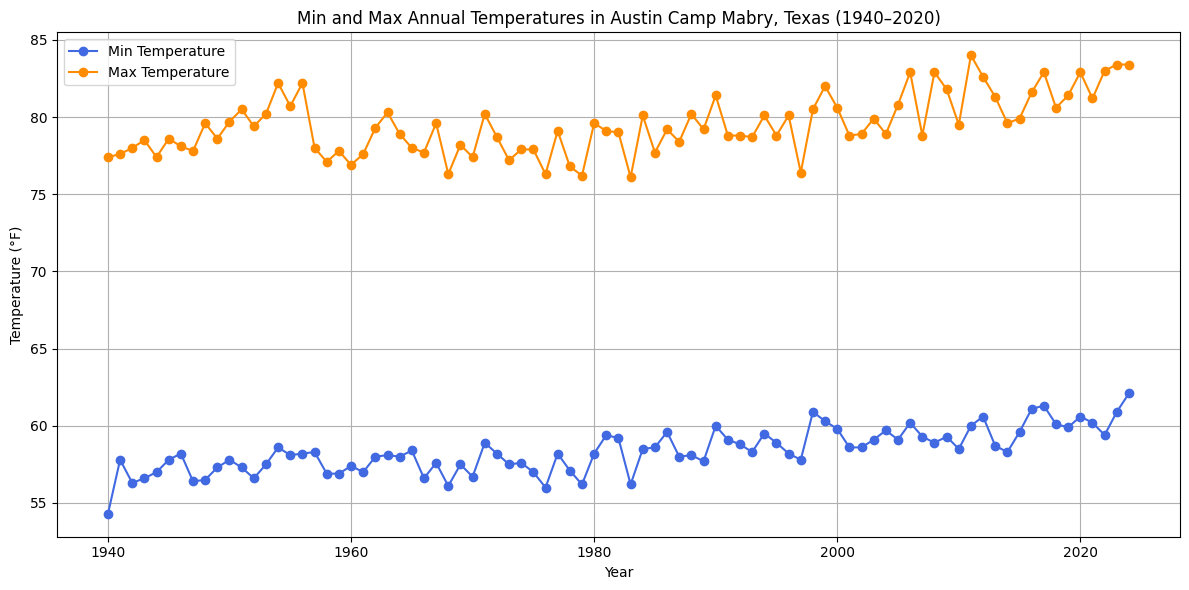

In [7]:
#Plotting Average Temperature Over Time (1940 - 2020)

plt.figure(figsize=(12, 6))
plt.plot(df_clean['YEAR'], df_clean['Min Temp'], label='Min Temperature', color='royalblue', marker='o')
plt.plot(df_clean['YEAR'], df_clean['Max Temp'], label='Max Temperature', color='darkorange', marker='o')
plt.title('Min and Max Annual Temperatures in Austin Camp Mabry, Texas (1940–2020)')
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Minimum and maximum temperatures in Austin Camp Mabry, Texas are also fluctuating and overall trend is upward over the time.
The minimum temperature appears to have risen from around 56~58°F in 1940s to above 60°F in the 2010s and early 2020s.
The maximum temperature appears to increase from 77~78°F in the 1940s to around 82~84°F in the 2010s~2020s.
There is greater fluctuation in maximum temperatures starting from the late 1990s to 2020.
However, minimum temperatures shows short-term dips.

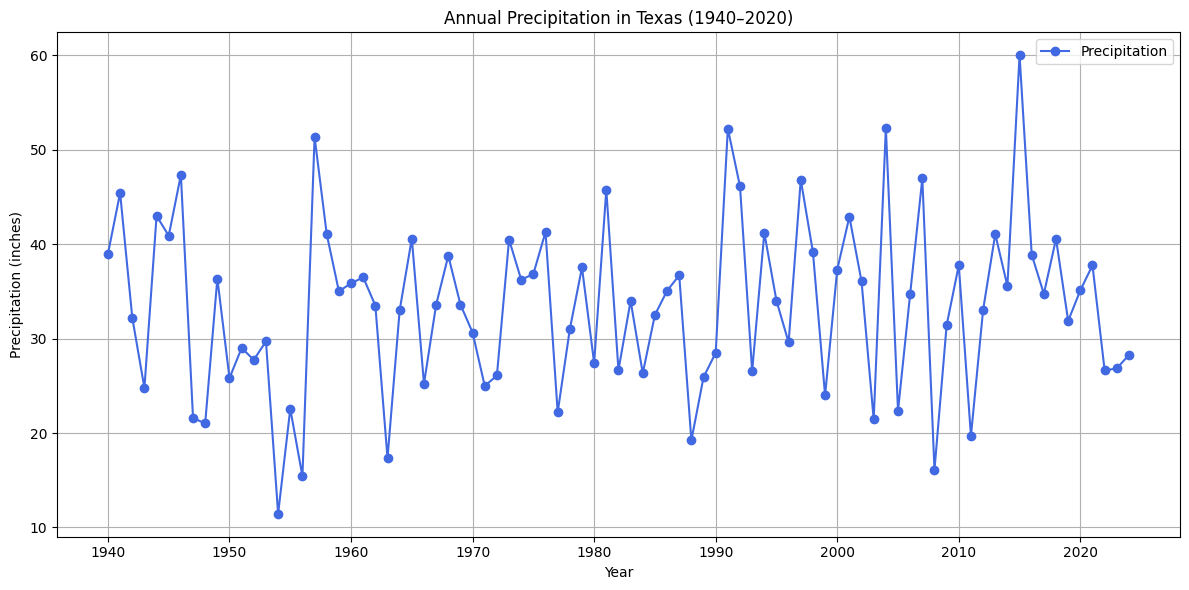

In [8]:
#Plotting Precipitation Over Time

plt.figure(figsize=(12, 6))
plt.plot(df_clean['YEAR'], df_clean['Precipitation'], marker='o', label='Precipitation', color='royalblue')
plt.title('Annual Precipitation in Texas (1940–2020)')
plt.xlabel('Year')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.legend()
plt.xticks(ticks=range(1940, 2030, 10))
plt.tight_layout()
plt.show()

The precipitation in Austin Camp Mabry, Texas from 1940 - 2020 shows high year-to-year variability, with no strong long term upward
or downard trend. This shows that rainfall is highly irregular which also means prone to both droughts and wet years in this area.
The dry years are 1954, 1956, 1963, 1988, 2008 and 2011; below 20 inches of precipitation. The wet years are 1957, 1991, 2004 which exceed 50 inches and there is one year exceeds 60 inches of rain, 2015. 

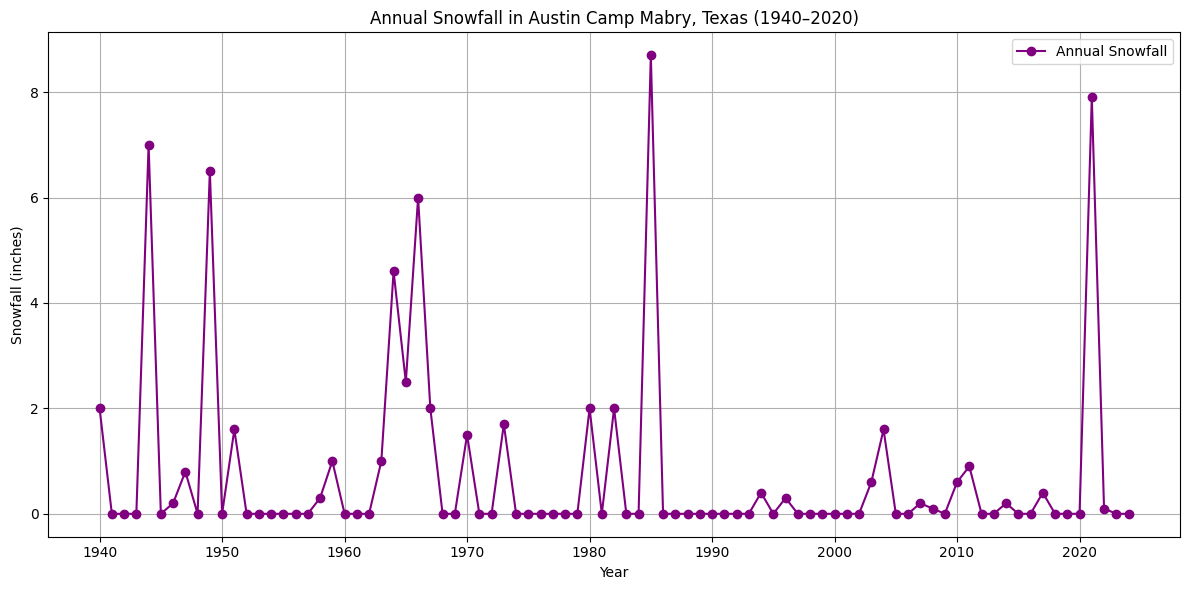

In [9]:
#Plotting Snow Over Time

plt.figure(figsize=(12, 6))
plt.plot(df_clean['YEAR'], df_clean['SNOW'], marker='o', color='purple', label='Annual Snowfall')
plt.title('Annual Snowfall in Austin Camp Mabry, Texas (1940–2020)')
plt.xlabel('Year')
plt.ylabel('Snowfall (inches)')
plt.grid(True)
plt.legend()
plt.xticks(ticks=range(1940, 2030, 10))
plt.tight_layout()
plt.show()

It looks like snowfall is generally rare in Austin Camp Mabry, with most years recording zero or near-zero snowfall.

In [10]:
#Correlation Between Average Temperature and Precipitation

correlation = df_clean['Avg. Temp'].corr(df_clean['Precipitation'])
print(f"Correlation between temperature and precipitation: {correlation:.2f}")

Correlation between temperature and precipitation: -0.22


The negative sign indicates an inverse relationship; as average temperature increases, precipitation tends to slightly
decrease,and vice versa. 
The value of -0.22 is week, suggeting that temperature and precipitation are not really correlated. 

In [11]:
# Correlation between Precipitation and Snowfall

correlation_snow = df_clean['Precipitation'].corr(df_clean['SNOW'])
print(f"Correlation between precipitation and snowfall: {correlation_snow:.2f}")

Correlation between precipitation and snowfall: 0.04


The correlation between precipitation and snowfall is almost close to 0. From this result, we can say that there is
no linear relationship between them.

I could not find the groundwater level of Austin Camp Mabry but somewhere between Austin and Camp Mabry.

In [12]:
#API Call for Groundwater Level at Austin, Texas

site = '08156800' 
start_date = '2000-01-01'
end_date = '2024-04-22'

df_discharge = nwis.get_record(sites=site, service='dv', start=start_date, end=end_date, parameterCd='00060')

df_discharge.head()

,site_no,00060_Maximum,00060_Maximum_cd,00060_Minimum,00060_Minimum_cd,00060_Mean,00060_Mean_cd
datetime,,,,,,,
2000-01-01 00:00:00+00:00,08156800,NaN,NaN,NaN,NaN,0.0,A
2000-01-02 00:00:00+00:00,08156800,NaN,NaN,NaN,NaN,0.0,A
2000-01-03 00:00:00+00:00,08156800,NaN,NaN,NaN,NaN,0.0,A
2000-01-04 00:00:00+00:00,08156800,NaN,NaN,NaN,NaN,0.0,A
2000-01-05 00:00:00+00:00,08156800,NaN,NaN,NaN,NaN,0.0,A


Here are the descriptions of what those columns mean.

00060_Maximum: Daily maximum discharge, 00060_Maximum_cd: Qualifier code for the max value,
00060_Minimum: Daily minimum discharge, 00060_Minimum_cd: Qualifier for the min value,
00060_Mean: Daily mean (average) discharge, 00060_Mean_cd: Qualifier code for the mean value

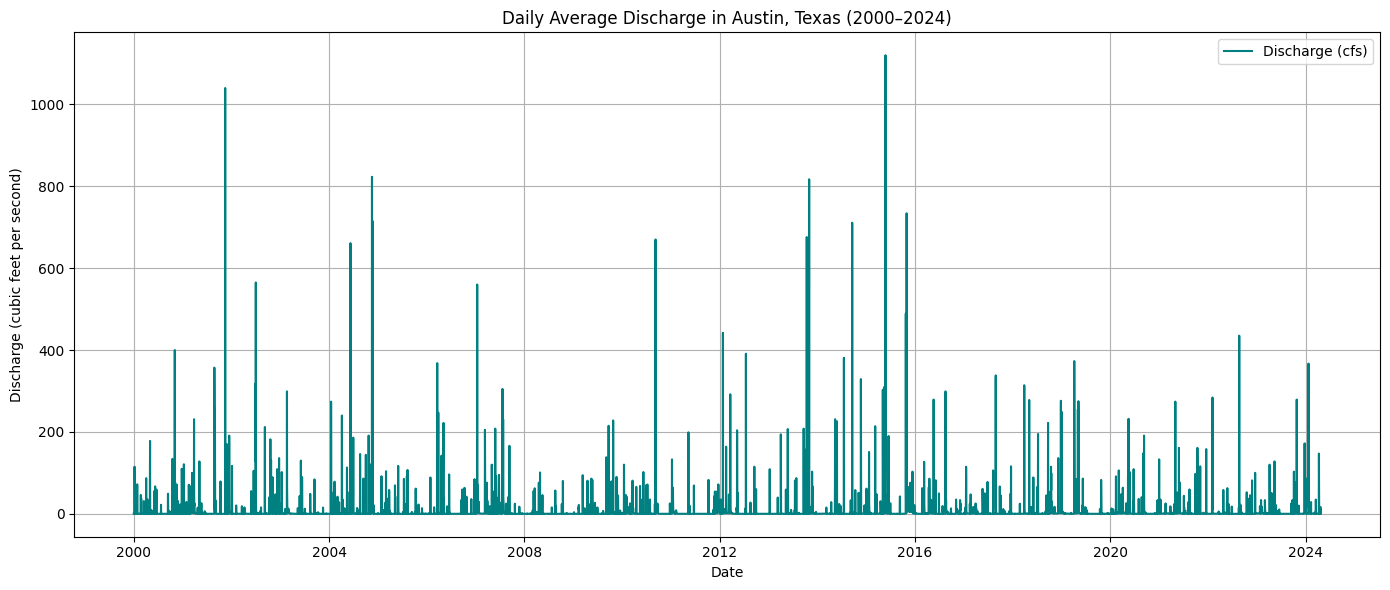

In [13]:
#Plotting Daily Average Discharge in Austin, Texas

plt.figure(figsize=(14, 6))
plt.plot(df_discharge.index, df_discharge['00060_Mean'], color='teal', label='Discharge (cfs)')
plt.title('Daily Average Discharge in Austin, Texas (2000–2024)')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/8p/2flq48dn0nq0x83wdjqtjlrm0000gn/T/ipykernel_52406/1265933279.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_discharge = df_discharge['00060_Mean'].resample('Y').mean()


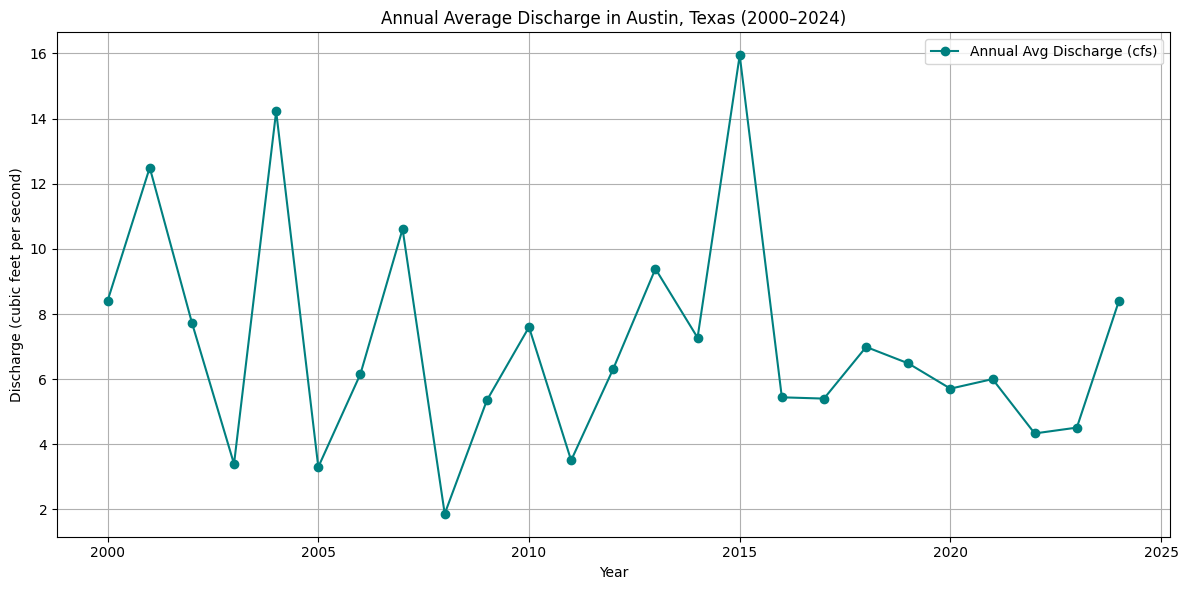

In [14]:
#Grouping by Year
annual_discharge = df_discharge['00060_Mean'].resample('Y').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(annual_discharge.index.year, annual_discharge.values, marker='o', color='teal', label='Annual Avg Discharge (cfs)')
plt.title('Annual Average Discharge in Austin, Texas (2000–2024)')
plt.xlabel('Year')
plt.ylabel('Discharge (cubic feet per second)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In early 2000s, there were relatively high values in 2001 and 2004.
A noticeable peak appears in 2015, reaching nearly 16 cfs and this matches with the highest peak from the annual precipitation
plot earlier. 
Recent years like 2020 ~ 2024, the discharge values have become more stable and generally lower, staying within the 4 to 7 cfs range. 

In [15]:
#Correlation Between Precipitation and Daily Discharge

annual_precip = df_clean[['YEAR', 'Precipitation']].copy()
annual_precip.set_index('YEAR', inplace=True)

annual_discharge = df_discharge['00060_Mean'].resample('Y').mean()
annual_discharge.index = annual_discharge.index.year

combined = pd.merge(annual_precip, annual_discharge, left_index=True, right_index=True)
combined.columns = ['Precipitation', 'Discharge']

correlation_gw = combined['Precipitation'].corr(combined['Discharge'])
print(f"Correlation between precipitation and groundwater discharge: {correlation_gw:.2f}")

Correlation between precipitation and groundwater discharge: 0.91


/var/folders/8p/2flq48dn0nq0x83wdjqtjlrm0000gn/T/ipykernel_52406/472870261.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_discharge = df_discharge['00060_Mean'].resample('Y').mean()


Correlation = 0.91 is very strong positive correlation. This basically means when precipitation increases, groundwater discharge
also increases significantly and when precipitation decreases, the dischage tends to decrease as well. The relationship is almost
linear. 

In [16]:
#Correlation Between Temperature and Daily Discharge

annual_temp = df_clean[['YEAR', 'Avg. Temp']].copy()
annual_temp.set_index('YEAR', inplace=True)

combined_temp_discharge = pd.merge(annual_temp, annual_discharge, left_index=True, right_index=True)
combined_temp_discharge.columns = ['Avg. Temp', 'Discharge']

correlation_temp_gw = combined_temp_discharge['Avg. Temp'].corr(combined_temp_discharge['Discharge'])
print(f"Correlation between temperature and groundwater discharge: {correlation_temp_gw:.2f}")

Correlation between temperature and groundwater discharge: -0.48


Correlation of -0.48 suggests a moderate negative relationship. This means that as average temperature increases, groundwater discharge
tends to decrease.

< Summary >
This study investigates long-term climate trends at Austin Camp Mabry, Texas, using comprehensive weather and groundwater data from 1940 to 2020. The site was selected for its exceptional data completeness and consistency, which are essential for meaningful climate analysis. Over the decades, average, minimum, and maximum temperatures have all shown a rising trend, particularly accelerating after 2000, indicating a warming climate. Annual precipitation, on the other hand, exhibits high interannual variability with no clear long-term trend, while snowfall remains rare and sporadic. Correlation analyses revealed a weak negative relationship between average temperature and precipitation (–0.22), and almost no correlation between precipitation and snowfall (0.04). However, precipitation and groundwater discharge are strongly positively correlated (0.91), suggesting that wetter years significantly increase streamflow. A moderate negative correlation (–0.48) between temperature and groundwater discharge implies that higher temperatures may reduce discharge levels, possibly due to increased evaporation or soil drying. These findings highlight how warming and precipitation patterns are shaping hydrological responses in central Texas.

Before start building a supervised model for drought prediction analysis, we need 'Drought' column.

A year is consided a drought year if annual precipitation is below 30% percentile and average annual temperature is
above 70% percentile.

In [38]:
#Creating 'Drought' column

precip_thresh = df_clean['Precipitation'].quantile(0.30)
temp_thresh = df_clean['Avg. Temp'].quantile(0.70)
df_clean['Drought'] = ((df_clean['Precipitation'] < precip_thresh) & 
                       (df_clean['Avg. Temp'] > temp_thresh)).astype(int)

df_clean.head()
#df_clean.shape

,STATION,YEAR,Avg. Temp,Min Temp,Max Temp,Extreme Min Temp,Ext. Max Temp,Precipitation,Ext. Max Prcp,SNOW,Ext. Max Snowfall,Drought
0,USW00013958,1940,65.9,54.3,77.4,10,102,38.97,3.00,2.0,2.0,0
1,USW00013958,1941,67.7,57.8,77.6,26,100,45.41,3.20,0.0,0.0,0
2,USW00013958,1942,67.2,56.3,78.0,18,101,32.22,2.60,0.0,0.0,0
3,USW00013958,1943,67.5,56.6,78.5,13,104,24.76,2.65,0.0,0.0,0
4,USW00013958,1944,67.2,57.0,77.4,19,103,42.98,3.90,7.0,3.9,0


In [39]:
df_clean.shape

(85, 12)

In [32]:
#Supervised Model: Logistic Regreesion

X = df_clean[['Avg. Temp', 'Min Temp', 'Max Temp', 'Extreme Min Temp',
              'Ext. Max Temp', 'Precipitation', 'Ext. Max Prcp',
              'SNOW', 'Ext. Max Snowfall']]
y = df_clean['Drought']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[15  0]
 [ 1  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.50      0.67         2

    accuracy                           0.94        17
   macro avg       0.97      0.75      0.82        17
weighted avg       0.94      0.94      0.93        17



0 = Non-Drought, 1 = Drought.

True Negative is 15, False Positive is 0, False Negative is 1 and True Positive 1.
This logistic regression model correctly classified 16 out of 17 years.

Precision for drought is 1.00. This happens when the model predicts a drought, it's always correct.
Recall for drought is 0.50. This means it misses 50% of the actual drought years. These two likely due to
class imbalance; only 2 drought years in test set.

F1-score for drought is 0.67 which shows the moderate performance. This means that the model gets some droughts right, 
but misses others either by false negatives or false positives. This also must be caused by the imbalance of the data.

Accuracy of this model is 94%.

Let's try the balanced data with the model.

In [41]:
#Balanced data + Logistic Regression Model

logreg2 = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg2.fit(X_train, y_train)
y_pred2 = logreg2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

Confusion Matrix:
[[15  0]
 [ 1  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.50      0.67         2

    accuracy                           0.94        17
   macro avg       0.97      0.75      0.82        17
weighted avg       0.94      0.94      0.93        17



Even after using class_weight = 'balanced', due to the small datasets, the result is same as before.

In [46]:
#Supervised Model: XGBoost Classifier Model

#Balancing the positive and negative classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False,
    eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

Confusion Matrix:
[[15  0]
 [ 0  2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         2

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



/Users/jihyekim/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


No false negatives or positives. Perfect classification after balancing the dataset.

In imbalanced and complex settings, linear models might oversimplify and often miss rare events. However,
Tree-based ensembles like XGBoost adaptively learn from mistakes, handle nonlinearities and pay more attention
to the minority class.

In [48]:
#Unsupervised Model: K-Means Clustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clean['Cluster'] = clusters

comparison = pd.crosstab(df_clean['Drought'], df_clean['Cluster'])
print("Cluster vs Drought Label:\n", comparison)

Cluster vs Drought Label:
 Cluster   0  1
Drought       
0        69  6
1        10  0


Cluster 0 represents non-drought. 69 instances are correctly grouped as non-drought, but 6 drought instances were incorrectly clustered as non-drought. Additionally, 10 non-drought instances were incorrectly clustered as drought.

K-means did not effectively identify drought year as a separate group because all of the
6 drought year was grouped as non-drought. This happened due to the small and imbalanced
drought class because K-means is sensitive to equal-size clusters.

< Summary >
For the final project, I implemented both supervised and unsupervised learning techniques to predict and explore drought conditions. On the supervised side, I applied logistic regression with class balancing to handle data imbalance, achieving an overall accuracy of 94% and an F1-score of 0.67 for the drought class. To improve performance, I used XGBoost with scale_pos_weight, which significantly outperformed logistic regression by achieving perfect accuracy and an F1-score of 1.00 for the drought class, making it the most effective model in this analysis. For the unsupervised approach, I used K-means clustering with two clusters to uncover patterns in the data without using drought labels. While it correctly grouped most non-drought years, it failed to capture actual drought years accurately, highlighting the limitations of unsupervised clustering in this context. Overall, XGBoost proved most suitable for this imbalanced classification task, while K-means offered exploratory insights but lacked predictive strength.
